# 🚀 Xarray v0.17.0 is here!


In [1]:
import numpy as np
import proplot as plot
import xarray as xr

xr.__version__

'0.17.0'

## Support for milliseond and microsecond frequencies in `cftime_range()`

The `cftime_range()` function in previous versions of xarray supported time
offsets not smaller than seconds. With v0.17.0, users are able to generate
cftime indices with millisecond and microsecond frequencies:


In [2]:
# Generate a cftime index with a frequency of 10 milliseconds
xr.cftime_range(start="2021-02-26T02:00:40", periods=10, freq="10ms")

CFTimeIndex([2021-02-26 02:00:40, 2021-02-26 02:00:40.010000, 2021-02-26 02:00:40.020000,
             2021-02-26 02:00:40.030000, 2021-02-26 02:00:40.040000, 2021-02-26 02:00:40.050000,
             2021-02-26 02:00:40.060000, 2021-02-26 02:00:40.070000, 2021-02-26 02:00:40.080000,
             2021-02-26 02:00:40.090000],
            dtype='object', length=10, calendar='gregorian', freq='10L')

In [3]:
# Generate a cftime index with a frequency of 20 microseconds
xr.cftime_range(start="2021-02-26T02:00:40", periods=10, freq="20us")

CFTimeIndex([2021-02-26 02:00:40, 2021-02-26 02:00:40.000020, 2021-02-26 02:00:40.000040,
             2021-02-26 02:00:40.000060, 2021-02-26 02:00:40.000080, 2021-02-26 02:00:40.000100,
             2021-02-26 02:00:40.000120, 2021-02-26 02:00:40.000140, 2021-02-26 02:00:40.000160,
             2021-02-26 02:00:40.000180],
            dtype='object', length=10, calendar='gregorian', freq='20U')

## `Dataset.plot.quiver`

`Dataset.plot.quiver` is a new feature in v0.17.0, that allows creating quiver
plots via matplotlib. Quiver plots are useful when visualizing velocity fields
and/or vector fields in a system of differential equations. To demonstrate the
new `Dataset.plot.quiver` API, I am going to use the
[van der pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator)
as an example:


In [4]:
s = 8.0
n = 40
x1 = np.linspace(-s, s, n)
X, Y = np.meshgrid(x1, x1)


def calculate_velocities(x, y, μ=0.6):
    """Compute velocities for van der pol oscillator using Lienard transform.

    Notes
    -----

    See https://en.wikipedia.org/wiki/Van_der_Pol_oscillator
    """
    u = μ * (x - (x ** 3) / 3 - y)
    v = x / μ
    return u, v

In [5]:
u, v = calculate_velocities(X, Y)  # calculate velocities
ds = xr.Dataset()
ds["u"] = xr.DataArray(
    u.reshape(4, 10, 40),
    dims=["time", "x", "y"],
    coords={"time": range(4), "x": range(10), "y": range(40)},
    attrs={"units": "m/s"},
)
ds["v"] = xr.DataArray(v.reshape(4, 10, 40), dims=["time", "x", "y"])
ds["magnitude"] = np.hypot(ds.u, ds.v)  # calculate the resultant velocity
ds.magnitude.attrs["long_name"] = "Van der pol Phase magnitude"
ds

<xarray.Dataset>
Dimensions:    (time: 4, x: 10, y: 40)
Coordinates:
  * time       (time) int64 0 1 2 3
  * x          (x) int64 0 1 2 3 4 5 6 7 8 9
  * y          (y) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
Data variables:
    u          (time, x, y) float64 102.4 87.69 74.51 ... -74.51 -87.69 -102.4
    v          (time, x, y) float64 -13.33 -12.65 -11.97 ... 11.97 12.65 13.33
    magnitude  (time, x, y) float64 103.3 88.59 75.46 ... 75.46 88.59 103.3

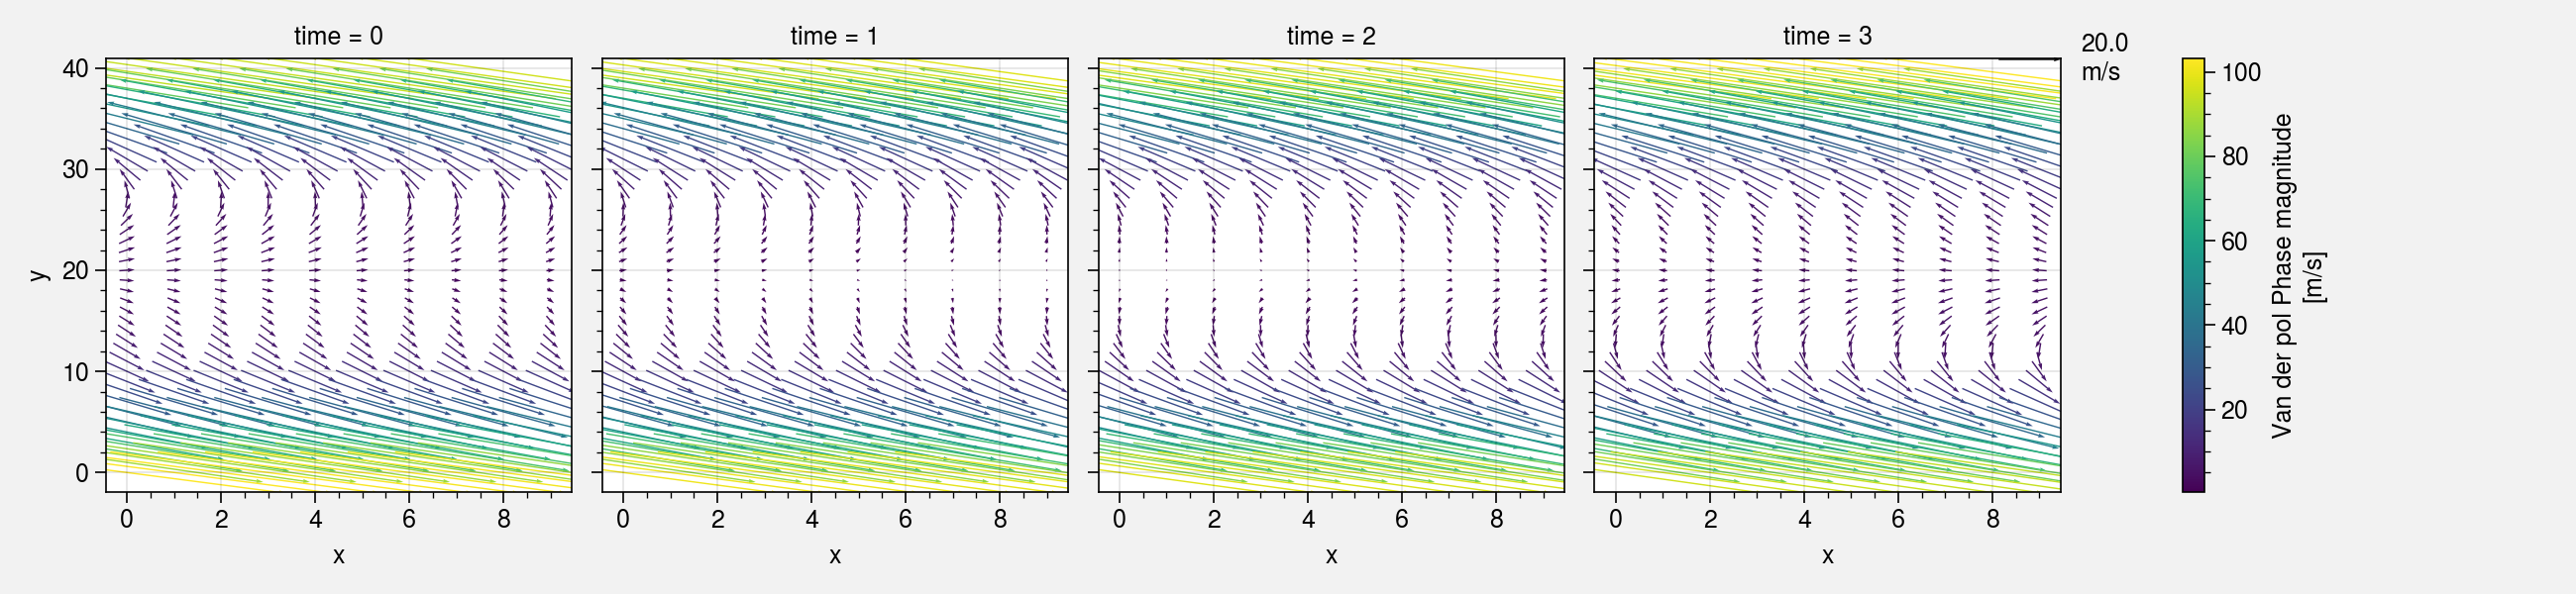

In [6]:
ax = ds.plot.quiver(x="x", y="y", u="u", v="v", scale=150, col="time", hue="magnitude")

You can notice that this isn't so neat because the points are so close to each
other. One remedy is to reduce the number of points to plot by slicing our
dataset:


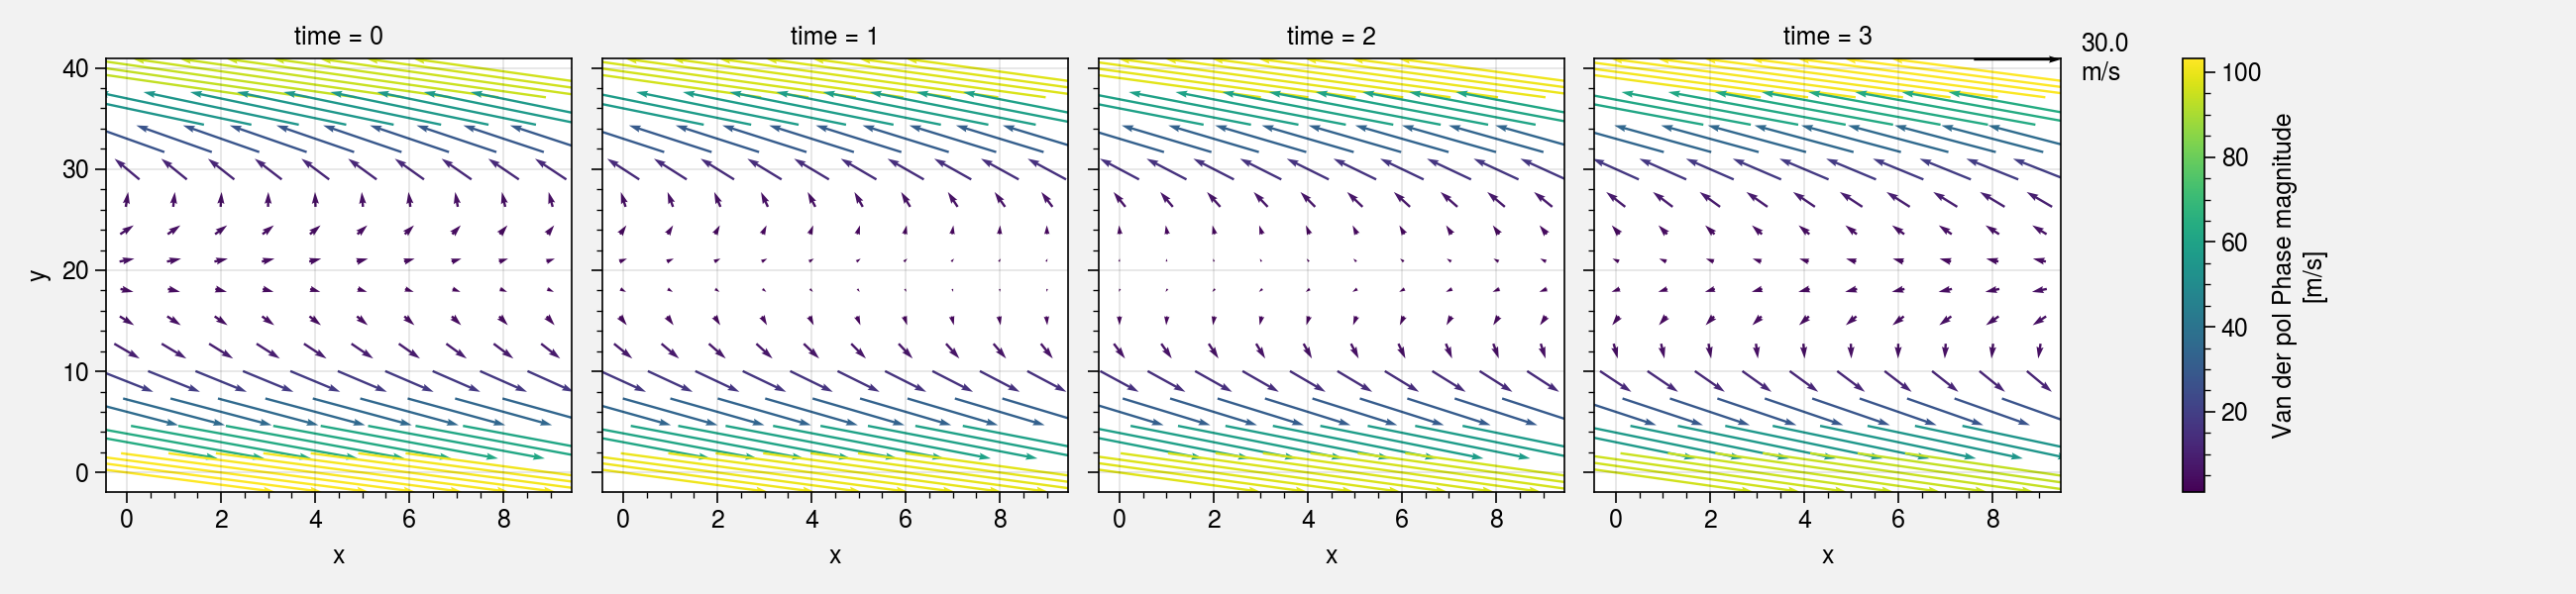

In [7]:
ds.isel(y=slice(None, None, 3)).plot.quiver(
    x="x",
    y="y",
    u="u",
    v="v",
    scale=150,
    col="time",
    angles="uv",
    units="height",
    hue="magnitude",
)

This is much better. We can clearly see that the arrows have increased in
size...


## Use fsspec urls in `xr.open_dataset()` and `xr.open_zarr()`

- Previously, when working with fsspec URLS, user had to create object mappers
  before calling `xr.open_dataset()` and `xr.open_zarr()`. With v0.17.0, we can
  use fsspec URLS directly
- v0.16.2 added functionality that allows using `open_dataset()` and
  `open_mfdataset()` to open zarr stores by specifying `engine='zarr'`


In [9]:
url = "gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/rsus/gn/v20170706/"
ds = xr.open_dataset(
    url,
    engine="zarr",
    backend_kwargs={"storage_options": {"token": None}, "consolidated": True},
)
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 288, time: 804)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 ...
  * time       (time) object 1948-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object ...
Dimensions without coordinates: bnds
Data variables:
    rsus       (time, lat, lon) float32 ...
Attributes: (12/47)
    CDI:                     Climate Data Interface version 1.8.0 (http://mpi...
    CDO:                     Climate Data Operators version 1.8.0 (http://mpi...
    Conventions:             CF-1.7 CMIP-6.0
    activity_id:             HighResMIP
    cmor_version:            3.2.3
    creation_date:           2017-07-02T15:44:22Z
    ...                      ...
    tracking_id:             hdl:21.14100/4ef5d037-ace7-4483-a151-928c9dd7ae4c
    variable_id:             rsus
    variant_label:           r1i1p1f1
    status:                  2019-11-16;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/4ef5d037-ace7-4483-a151-928c9dd7ae4c
    version_id:              v20170706

## Full changelog

The full changelog resides
[here](https://xarray.pydata.org/en/stable/whats-new.html#v0-17-0-24-feb-2021)
